# Valley analysis in LSDTopoTools

Wlecome to `plot-valley-analysis`! In order to run this notebook you need to have followed the installation instructions on the `lsdtt-notebooks` GitHub repository and make sure you have `lsdviztools` installed. This notebook plots the results of the LSDTopoTools valley analysis code. It will produce map plots of the valley defined from LSDTT. It also has a number of different options depending on what you're interested in doing. 

If you chose to run the terrace extraction it will make:
* Separate map plots of the floodplain and the terraces

If you chose to measure valley width it will make:
* Plots of the valley width vs distance downstream
* Map plots of the valley width measurements

**NOTE: This is a work in progress!** 

------------------------------------------------------

**If you use this code please cite**: Clubb, F. J., Mudd, S. M., Milodowski, D. T., Valters, D. A., Slater, L. J., Hurst, M. D., and Limaye, A. B.: Geomorphometric delineation of floodplains and terraces from objectively defined topographic thresholds, Earth Surf. Dynam., 5, 369–385, https://doi.org/10.5194/esurf-5-369-2017, 2017.

------------------------------------------------------

## Package imports and declaring variables

Import required packages and define the data directory and DEM name here.

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, MultiLineString
from pyproj import Transformer
import os
import numpy as np

# import some lsdtt modules
# import lsdviztools.lsdbasemaptools as bmt
# from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
# import lsdviztools.lsdmapwrappers as lsdmw
# import lsdttparamselector as ps

Let's define the data directory and the prefix of your DEM. **The path to the folder MUST have a '/' at the end.**

In [5]:
DataDirectory = '/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Valley_Centreline/Birs_Test11_180621/'
Base_file = "Birs_T11_Clipped"

## Valley plotting

This section makes map plot of the valley. First we'll read in the valley raster and make a plot against the shaded relief.

**NOTE: this is commented out at the moment due to issues with pip version of lsdviztools**

In [ ]:
# %matplotlib inline
# Drape_prefix = Base_file+"_valley"
# valley_img = lsdmw.BinaryDrape(DataDirectory,Base_file, Drape_prefix, cmap = "GnBu_r", alpha=1, save_fig=True)

## Valley width

In this section we'll make some plots of the valley width against distance.

In [ ]:
# Read in the valley width geojson
widths = gpd.read_file(DataDirectory+Base_file+'_valley_widths.geojson')
widths = widths[widths['total_valley_width'] > 0]

In [ ]:
# get the mean valley width
mean_width = widths['total_valley_width'].mean()

In [ ]:
# plot the raw width data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['distance_from_outlet'], widths['total_valley_width'], c='navy', lw=2)
ax.axhline(mean_width, ls='--', c='r')
ax.set_xlabel('Distance from outlet (m)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()

In [ ]:
# make a plot of the rolling average of widths

In [ ]:
reach_length = 100    # set the reach length to average over in metres
widths['rolling_width'] = widths.rolling(reach_length, center=True).mean()['total_valley_width']
widths['rolling_width_std'] = widths.rolling(reach_length, center=True).std()['total_valley_width']

In [ ]:
# plot the rolling width data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['distance_from_outlet'], widths['total_valley_width'], c='0.5', lw=2, alpha=0.5)
ax.plot(widths['distance_from_outlet'], widths['rolling_width'], c='k', lw=2)
ax.axhline(mean_width, ls='--', c='red')
ax.set_xlabel('Distance from outlet (m)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()

In [ ]:
widths

## Plotting a single reach along the valley centreline
This section is useful if you have run the code in tiles and want to make a composite plot of the valley width along the full valley. You will need a merged centreline of the valley as a line shapefile.

In [ ]:
# Read in the valley width geojson
widths = gpd.read_file(DataDirectory+Base_file+'_valley_widths.geojson')
widths = widths[widths['total_valley_width'] > 0]

In [ ]:
# name and path of the merged centreline
centreline_shp = '/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Valley_Centreline/Birs_valley_centreline_final.shp'
# the UTM EPSG code of your region. You need to set this so we can get the correct distances in metres.
UTM_EPSG_code = 'epsg:32632'

In [ ]:
# now read in the centreline to a geopandas geodataframe
centreline = gpd.read_file(centreline_shp)

# get the centreline in UTM
centreline_utm = centreline.to_crs(UTM_EPSG_code)
# set up the pyproj transformer
transformer = Transformer.from_crs("epsg:4326", UTM_EPSG_code)

In [ ]:
# get the distance of the widths along the line
def get_distance_along_line(row):
    #point = Point(row['longitude'], row['latitude'])
    # convert the point to UTM
    point = Point(transformer.transform(row['latitude'], row['longitude']))
    # getting the distance of the point along the line
    distance = centreline_utm.project(point)
    return(distance)
    
widths['centreline_dist'] = widths.apply(get_distance_along_line, axis=1)

In [ ]:
# make a plot of the valley width vs. distance along the merged centreline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['centreline_dist'], widths['total_valley_width'], c='navy', lw=2)
ax.axhline(mean_width, ls='--', c='r')
ax.set_xlabel('Distance along valley centreline (m)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()

## Plotting all the reaches along the valley centreline
In this section we will loop through all the directories in your subfolder and make a composite plot of the widths for each one.

In [6]:
# define the name of the base directory that you want to loop through
base_dir = '/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Valley_Centreline/'
# the name of the centreline shapefile - I am assuming it is located in the base directory
centreline_shp = base_dir+'Birs_valley_centreline_final.shp'
# the UTM EPSG code of your region. You need to set this so we can get the correct distances in metres.
UTM_EPSG_code = 'epsg:32632'

In [8]:
# now read in the centreline to a geopandas geodataframe
centreline = gpd.read_file(centreline_shp)
#centreline = centreline.dissolve()

# get the centreline in UTM
centreline_utm = centreline.to_crs(UTM_EPSG_code)
# set up the pyproj transformer
transformer = Transformer.from_crs("epsg:4326", UTM_EPSG_code)

# set up the master dataframe for storing all the width data together
widths = gpd.GeoDataFrame()

/home/bjdd72/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
centreline

,path,begin,end,geometry
0,Birs_T10_centreline_nodes.shp|layername=Birs_T...,2302570.0,9203750.0,"MULTILINESTRING ((7.21785 47.23365, 7.21787 47..."


In [10]:
# get the distance of the widths along the line. This just defines the code that will do this, but won't actually
# do anything until the next block.
def get_distance_along_line(row):
    #point = Point(row['longitude'], row['latitude'])
    # convert the point to UTM
    point = Point(transformer.transform(row['latitude'], row['longitude']))
    # getting the distance of the point along the line
    distance = centreline_utm.project(point)
    return(distance)

In [11]:
# loop through the subdirectories and read in the valley width geojsons, calculate the distance along the centreline
# and write to a new geodataframe. This might be slow!
for root, subdirs, files in os.walk(base_dir):
    for file in files:
        if '_valley_widths.geojson' in file:
            this_gdf = gpd.read_file(os.path.join(root,file))
            this_gdf = this_gdf[this_gdf['total_valley_width'] > 0]
            #this_gdf = this_gdf.drop(columns=['distance_from_outlet', 'node'])
            this_gdf['centreline_dist'] = this_gdf.apply(get_distance_along_line, axis=1)
            widths = widths.append(this_gdf, ignore_index=True)

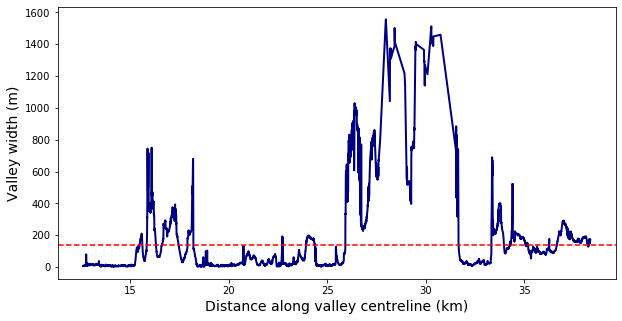

In [12]:
# sort by the distance along the centreline to make sure we're plotting in the right order
widths = widths.sort_values(by='centreline_dist')

# get the mean valley width
mean_width = widths['total_valley_width'].mean()

# make a plot of the valley width vs. distance along the merged centreline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['centreline_dist']/1000, widths['total_valley_width'], c='navy', lw=2)
ax.axhline(mean_width, ls='--', c='r')
ax.set_xlabel('Distance along valley centreline (km)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()
fig.savefig(base_dir+'Birs_valley_width.png', transparent=False)

## Bedrock geology

Add the plotting of the bedrock geology. We will load in the geology shapefile to a dataframe of polygons using geopandas. For each point along the valley centreline, we'll look to see if it intersects one of the polygons and assign it the appropriate bedrock type.

In [13]:
# read in the geology shapefile to a geopandas geodataframe
geology_gdf = gpd.read_file('/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Geology/Birs_Bedrock_Merged.shp')

In [14]:
# this is how you can check the coordinate system of a geodataframe.
geology_gdf.crs

{'init': 'epsg:4326'}

In [15]:
# change to UTM so we can do the buffering in metres
widths_utm = widths.to_crs(UTM_EPSG_code)
# buffer each part of the centreline to create a polygon that's 50 m in width
widths_utm['centreline_buffer'] = widths_utm['geometry'].buffer(50)
# convert back to WGS84
widths_utm['geometry'] = widths_utm['centreline_buffer']
buffered_widths = widths_utm.to_crs('epsg:4326')

/home/bjdd72/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
buffered_widths

,latitude,longitude,distance_from_outlet,flow_bearing,left_valley_width,node,orthogonal_bearing,right_valley_width,total_valley_width,geometry,centreline_dist,centreline_buffer
5129,47.251563,7.343354,14370.830100,30.354321,0.999764,16692110,120.354324,3.471317,6.323065,"POLYGON ((7.34291 47.25189, 7.34295 47.25192, ...",12607.444912,"POLYGON ((374613.126 5234488.574, 374616.782 5..."
5130,47.251582,7.343380,14365.658200,25.355295,3.471317,16688520,115.355293,0.999764,6.323065,"POLYGON ((7.34272 47.25158, 7.34272 47.25163, ...",12610.275695,"POLYGON ((374598.240 5234454.270, 374598.408 5..."
5131,47.251599,7.343379,14363.658200,21.290243,3.471317,16684929,111.290245,0.999764,6.323065,"POLYGON ((7.34272 47.25161, 7.34272 47.25165, ...",12612.277230,"POLYGON ((374598.241 5234457.159, 374598.496 5..."
5132,47.251618,7.343379,14360.486300,18.937490,3.471317,16681338,108.937492,1.827996,7.209403,"POLYGON ((7.34272 47.25163, 7.34272 47.25167, ...",12614.278301,"POLYGON ((374598.247 5234459.163, 374598.504 5..."
5133,47.251635,7.343378,14359.658200,16.555672,2.999293,16677747,106.555672,2.999293,7.998115,"POLYGON ((7.34272 47.25165, 7.34272 47.25169, ...",12616.268242,"POLYGON ((374598.253 5234461.150, 374598.509 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5124,47.394067,7.415440,680.972107,98.510261,69.693436,2679913,188.510254,102.221985,173.910995,"POLYGON ((7.41593 47.39437, 7.41597 47.39434, ...",38341.924556,"POLYGON ((380460.283 5250207.167, 380463.559 5..."
5125,47.394049,7.415467,679.800781,101.309921,72.330582,2683673,191.309921,98.995506,173.323792,"POLYGON ((7.41548 47.39450, 7.41554 47.39450, ...",38344.733680,"POLYGON ((380426.671 5250222.004, 380431.572 5..."
5126,47.394050,7.415493,677.801270,98.510261,71.673393,2683674,188.510254,99.950523,173.623398,"POLYGON ((7.41551 47.39450, 7.41557 47.39450, ...",38346.746709,"POLYGON ((380428.911 5250221.997, 380433.811 5..."
5127,47.394050,7.415520,675.801758,98.510261,71.673393,2683675,188.510254,97.970711,171.643311,"POLYGON ((7.41553 47.39450, 7.41560 47.39450, ...",38348.726025,"POLYGON ((380430.667 5250222.001, 380435.568 5..."


In [17]:
# find if each centreline polygon intserects the geology. To do this we use what's called a "spatial join"
# it will join the polygon from the geology shapefile with the widths dataframe if they intersect in geographic space.
widths_plus_geology = gpd.sjoin(buffered_widths, geology_gdf, how='left', op='intersects')

/home/bjdd72/miniconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [18]:
# geopandas doesn't like it if there is more than one column with a shape in it. so let's remove the buffered shapes.
widths_plus_geology = widths_plus_geology.drop(columns=('centreline_buffer'))

In [19]:
# let's write the new dataframe to a shapefile so we can load it in to QGIS and test if it worked
widths_plus_geology.to_file('/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Geology/Birs_widths_plus_geology.shp')

In [20]:
widths_plus_geology

,latitude,longitude,distance_from_outlet,flow_bearing,left_valley_width,node,orthogonal_bearing,right_valley_width,total_valley_width,geometry,centreline_dist,index_right,SYMBOL,layer,path,LITHOLOGY,a
5129,47.251563,7.343354,14370.830100,30.354321,0.999764,16692110,120.354324,3.471317,6.323065,"POLYGON ((7.34291 47.25189, 7.34295 47.25192, ...",12607.444912,102.0,15200115,Bedrock_096_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None
5129,47.251563,7.343354,14370.830100,30.354321,0.999764,16692110,120.354324,3.471317,6.323065,"POLYGON ((7.34291 47.25189, 7.34295 47.25192, ...",12607.444912,103.0,15200117,Bedrock_096_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M_LS,None
5130,47.251582,7.343380,14365.658200,25.355295,3.471317,16688520,115.355293,0.999764,6.323065,"POLYGON ((7.34272 47.25158, 7.34272 47.25163, ...",12610.275695,102.0,15200115,Bedrock_096_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None
5130,47.251582,7.343380,14365.658200,25.355295,3.471317,16688520,115.355293,0.999764,6.323065,"POLYGON ((7.34272 47.25158, 7.34272 47.25163, ...",12610.275695,103.0,15200117,Bedrock_096_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M_LS,None
5131,47.251599,7.343379,14363.658200,21.290243,3.471317,16684929,111.290245,0.999764,6.323065,"POLYGON ((7.34272 47.25161, 7.34272 47.25165, ...",12612.277230,102.0,15200115,Bedrock_096_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5124,47.394067,7.415440,680.972107,98.510261,69.693436,2679913,188.510254,102.221985,173.910995,"POLYGON ((7.41593 47.39437, 7.41597 47.39434, ...",38341.924556,NaN,NaN,NaN,NaN,NaN,NaN
5125,47.394049,7.415467,679.800781,101.309921,72.330582,2683673,191.309921,98.995506,173.323792,"POLYGON ((7.41548 47.39450, 7.41554 47.39450, ...",38344.733680,NaN,NaN,NaN,NaN,NaN,NaN
5126,47.394050,7.415493,677.801270,98.510261,71.673393,2683674,188.510254,99.950523,173.623398,"POLYGON ((7.41551 47.39450, 7.41557 47.39450, ...",38346.746709,NaN,NaN,NaN,NaN,NaN,NaN
5127,47.394050,7.415520,675.801758,98.510261,71.673393,2683675,188.510254,97.970711,171.643311,"POLYGON ((7.41553 47.39450, 7.41560 47.39450, ...",38348.726025,NaN,NaN,NaN,NaN,NaN,NaN


['M' 'M_LS' nan 'LS' 'C' 'SS']


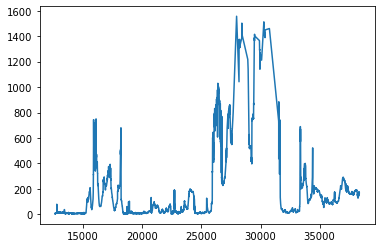

In [33]:
plt.plot(widths_plus_geology['centreline_dist'], widths_plus_geology['total_valley_width'])
lithologies = widths_plus_geology['LITHOLOGY'].unique()
print(lithologies)

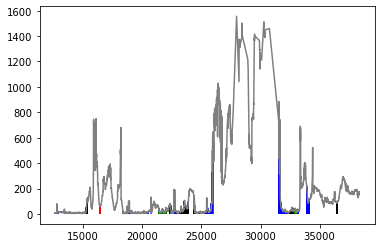

In [41]:
colours = ['red', 'blue', 'yellow', 'black', 'grey', 'green']
plt.plot(widths_plus_geology['centreline_dist'], widths_plus_geology['total_valley_width'], c='grey', zorder=2)
for i, lith in enumerate(lithologies):
    this_df = widths_plus_geology[widths_plus_geology['LITHOLOGY'] == lith]
    plt.vlines(this_df['centreline_dist'], ymin=0, ymax=this_df['total_valley_width'], colors=colours[i], alpha=0.5, zorder=1)